This is to evaluate the teaching excellence award questions through the years to try to identify the questions that have the most feedback and interaction. We may find that many times over the years, a question will be left with, "I don't know," or left blank. 

Scales are on a 0 - 10 scale.

In [1]:
import pandas as pd
import numpy as np

import re
import os
from pathlib import Path
import sys

import warnings
warnings.filterwarnings('ignore')

from utilities import retrieve_and_open_csv_files
from preprocess import configure_dataframe

# Create path to data
DATA_PATH = Path.cwd()/'Data'

# List of years' responses for first set of years (2014 - 2019)
years = ['2014-2015', '2016', '2017', '2018', '2019b']

Since the data was not formatted the same way each year, I am going to load each year separately. 

In [2]:
# Load 2014 - 2019 data
combined_df = []
for year in years:
    temp_tbl = configure_dataframe(retrieve_and_open_csv_files(DATA_PATH, keyword = year))
    temp_tbl['year'] = temp_tbl['Timestamp'].dt.year[0]
    combined_df.append(temp_tbl)

combined14_19 = (pd.concat(combined_df)
                   .reset_index(drop = True)
                )

In [3]:
# Load 2022 - 2023 data
df2022 = retrieve_and_open_csv_files(DATA_PATH, keyword='2022')
df2023 = retrieve_and_open_csv_files(DATA_PATH, keyword='2023')

## Questions Answered In 2014 - 2019


 1. TEACH - How effectively does the nominee use teaching methods and techniques that inspire high student achievement?
 1. TEACH - How does the nominee use effective methods and techniques that inspire high student achievement?
 2. TECH - How does the nominee demonstrate proficiency with technology and digital resources to enhance student success inside and outside the classroom?
 2. TECH - To what degree does the nominee demonstrate proficiency with technology and digital resources to enhance student success inside and outside the classroom?
 3. CARE - To what degree does the nominee support student retention through addressing non-cognitive issues?
 3. CARE - How does the nominee support student retention through addressing non-cognitive issues?
 4. INNOVATION - Rate how well the nominee fosters innovation in teaching, learning, and student success?
 4. INNOVATION - How does the nominee foster innovation in teaching, learning, and student success?
 5. LEADERSHIP - How much does the nominee show leadership through participation in college committees, task forces, associations, teams, etc.?
 5. LEADERSHIP - How does the nominee show leadership through participation in college committees, task forces, associations, teams, etc.?


## Isolate just the integer rows and gather average scores. Timestamps are unique in this dataset.

In [4]:
from preprocess import collect_avg

# Question category average
quest_cat_avg = collect_avg(combined14_19, ['year', 'question_cat'], 'Int')

(quest_cat_avg.sort_values(['year', 'question_cat'])
     .pivot_table(index = ['question_cat'], columns = ['year'], values = ['mean', 'stdev'])
)

mean                                             stdev  \
year              2014      2016      2017      2018      2019      2014   
question_cat                                                               
CARE          9.711864  9.529412  9.588785  9.817308  9.647059  0.897306   
INNOVATION    9.661017  9.564706  9.728972  9.692308  9.529412  0.859540   
LEADERSHIP    9.135593  9.352941       9.0  8.961538  9.088235  1.679007   
TEACH         9.754237  9.717647  9.831776  9.769231  9.705882  0.738865   
TECH          9.508475  9.576471  9.401869  9.471154  9.470588  1.130356   

                                                      
year              2016      2017      2018      2019  
question_cat                                          
CARE          1.150447  1.413902  0.497848  0.773906  
INNOVATION    1.040227  0.721242  0.859859  1.107421  
LEADERSHIP    1.493684  1.957087  2.042857  1.564137  
TEACH         0.810816  0.522801  0.561392  0.798841  
TECH          0.943354  1.212045  1.173798  1.107421

In [5]:
# Make averages table
averages = (collect_avg(combined14_19, ['Timestamp', 'question_cat'], 'Int')
            )

# Add year
averages['year'] = averages['Timestamp'].dt.year

# Individual scores
ind_scores = (averages.merge(quest_cat_avg, how = 'left', on = ['question_cat', 'year'])
                      .rename(columns = {'mean_x':'ind_mean',
                                         'mean_y':'quest_cat_avg',
                                         'stdev_y':'stdev'})
                      .drop('stdev_x', axis = 1)
                      .drop_duplicates(['Timestamp', 'question_cat'])
             )

ind_scores['num_sdev'] = [(i - j)/k for i, j, k in zip(ind_scores['quest_cat_avg'], ind_scores['ind_mean'], ind_scores['stdev'])]

ind_scores['>_1_sdev'] = ['> 1 Sdevs' if abs(i) > 1 else 'Within 1 Sdevs' for i, j in zip(ind_scores['num_sdev'], ind_scores['stdev'])]

ind_scores[ind_scores['>_1_sdev'] == 'Within 1 Sdevs'].head()

ind_scores['ind_mean'] = ind_scores['ind_mean'].astype(float)


In [6]:
%%html
<style>
table {float:left}
</style>

### Kernel Density Plots of Ratings

To view the distributions of the ratings, I created these density plots. As we already know from the table, the mean of the ratings for each question is above 9.0, which I would argue makes the ratings unhelpful or unnecessary. 

The average rating for each area of interest are shown below:

|**Teaching_Category** | **Average_Rating**|
|:---------------------|:-----------------:|
|CARE | 9.667411 | 
|INNOVATION | 9.656250 | 
|LEADERSHIP | 9.100446 | 
|TEACH | 9.765625 | 
|TECH | 9.484375 | 

<br><br><br><br><br><br><br><br><br>

**TukeyHSD Multiple Comparison of Means $\alpha$ = 0.05**

A pairwise comparison of the means of the ratings for each area of interest shows that there is a statistically significant difference between the means of CARE and LEADERSHIP (p = 0.000), INNOVATION and LEADERSHIP (p = 0.000), TEACH and LEADERSHIP (p = 0.000), TECH and LEADERSHIP (p = 0.000), and TEACH and TECH (p = 0.0028). Given that there is a statistically signficant difference in the means of the ratings between all other categories and LEADERSHIP suggests that this question needs to be scrapped (if possible) or significantly rewritten or reconsidered. The differences between TEACH and TECH may highlight that TECH is also a more difficult category for students to accurately gauge.

In [8]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Conduct Tukey HSD test
tukey_results = pairwise_tukeyhsd(endog = ind_scores['ind_mean'],
                                 groups = ind_scores['question_cat'],
                                 alpha = 0.05)


# View summary output of TukeyHSD
tukey_results.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
CARE,INNOVATION,-0.0112,0.9999,-0.2244,0.2019,False
CARE,LEADERSHIP,-0.5695,0.0,-0.7827,-0.3564,True
CARE,TEACH,0.0987,0.7136,-0.1145,0.3118,False
CARE,TECH,-0.1839,0.1283,-0.397,0.0293,False
INNOVATION,LEADERSHIP,-0.5583,0.0,-0.7714,-0.3452,True
INNOVATION,TEACH,0.1099,0.6231,-0.1033,0.323,False
INNOVATION,TECH,-0.1726,0.1758,-0.3858,0.0405,False
LEADERSHIP,TEACH,0.6682,0.0,0.455,0.8813,True
LEADERSHIP,TECH,0.3857,0.0,0.1725,0.5988,True
TEACH,TECH,-0.2825,0.0028,-0.4957,-0.0694,True


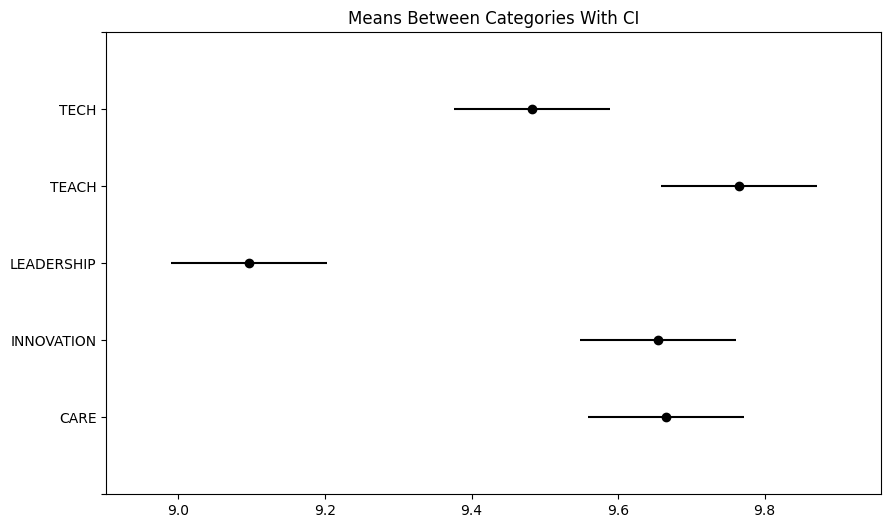

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the means of each category with their confidence intervals 
tukey_results.plot_simultaneous()
plt.title('Means Between Categories With CI')
plt.show()

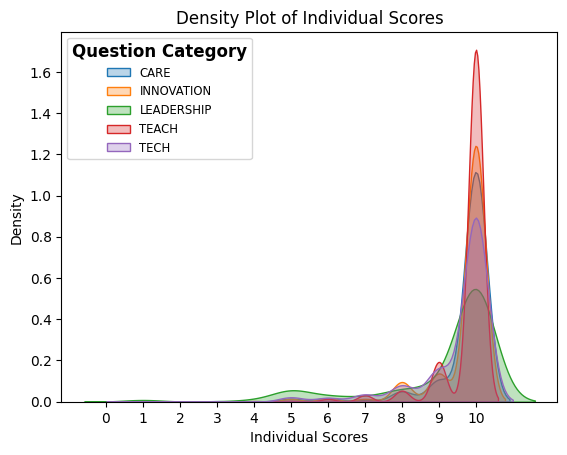

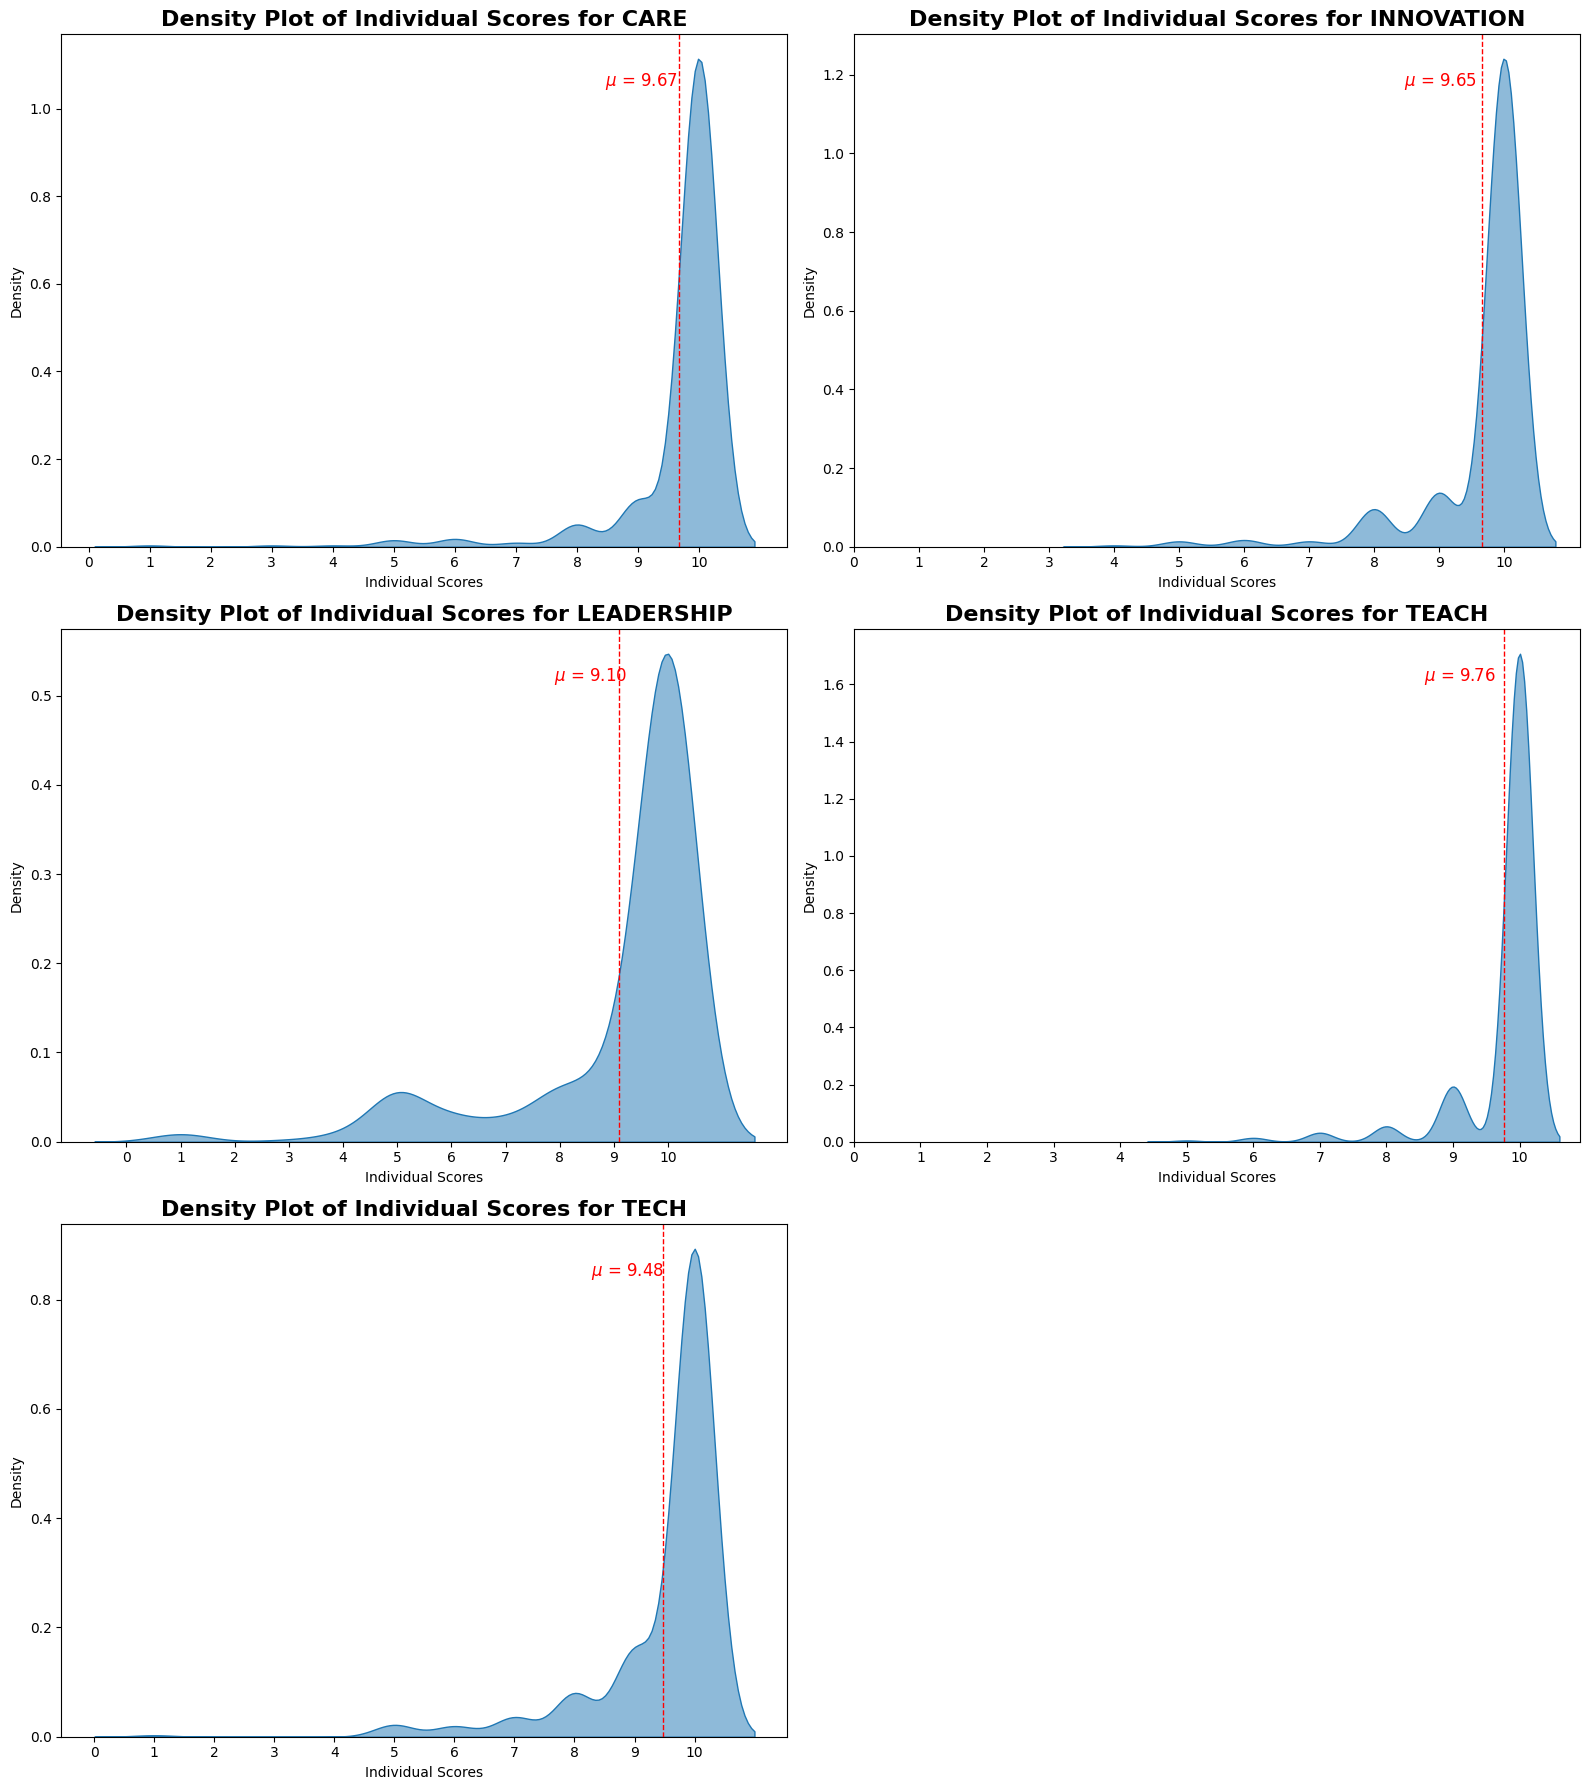

In [10]:
# Create density plot that plots 'ind_mean' on one plot
for cat in ind_scores['question_cat'].unique():
    # Isolate each category in its own df
    subset = ind_scores[ind_scores['question_cat'] == cat]
    sns.kdeplot(data = subset,
                x = 'ind_mean',
                fill = True,
                common_norm = False,
                alpha = 0.3,
                label = cat)

# Make title, labels, legend, and set xticks
plt.title('Density Plot of Individual Scores')
plt.xlabel('Individual Scores')
plt.ylabel('Density')
plt.xticks(range(0, 11))
(plt.legend(title = 'Question Category', 
           loc = 'upper left',
           title_fontsize = 'large', 
           fontsize = 'small')
    .get_title()
    .set_fontweight('bold')
)

# Show plot
plt.show()

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 18))
axes = axes.flatten()

categories = ind_scores['question_cat'].unique()
for i, cat in enumerate(ind_scores['question_cat'].unique()):
    # Isolate each category in its own df
    subset = ind_scores[ind_scores['question_cat'] == cat]
    
    mean_val = subset['ind_mean'].mean()
    
    # Use the ith subplot for the current category
    ax = axes[i]
    
    # Create KDE plot
    sns.kdeplot(data = subset, 
                x = 'ind_mean',
                fill = True,
                common_norm = False,
                alpha = 0.5,
                ax = ax)
    
    # Add mean
    ax.axvline(mean_val,
              color = 'red',
              linestyle = '--',
              linewidth = 1)
    
    # Add text of mean to chart
    ax.text(mean_val - 1.2,
            ax.get_ylim()[1] * 0.90,
            f'$\\mu$ = {mean_val:.2f}',  
            color = 'red',
            fontsize = 12)

    
    # Set title, x and y labels, and xticks
    ax.set_title(f'Density Plot of Individual Scores for {cat}', fontsize = 16, fontweight = 'bold')
    ax.set_xlabel('Individual Scores')
    ax.set_ylabel('Density')
    ax.set_xticks(range(0, 11))

# If the number of categories is less than the number of subplots, hide the unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


What we see from this is that nearly all of the scorings are within 1 Sdevs. Nearly 90% (88.36%) of all scores are 1 standard deviation or lower. So the scoring is definitely not a good metric. As was stated in FDT, if a person is getting nominated, then we'd expect that they'd have high marks for virtually everything. This is a case in which we have severe selection bias and should consider removing any kind of rating questions. A rating question might be insightful if all students throughout the college were being asked to rate their professors based on these categories. However, since students or faculty voluntarily nominate someone, then by its very nature, the nominees are going to have high ratings.  

## Examine String Answers

This is the meat of the analysis as FDT team wants to know which responses had the most amount of engagement.

In [11]:
# Isolate string responses
string_resp = (combined14_19[combined14_19['row_type'] == 'String']
                   .reset_index(drop = True)
                   .fillna('No Response')
              )

# Count the number of words in each response
string_resp['num_of_words'] = [len(string_resp['value'][i].strip().split(' ')) for i in range(len(string_resp))]

# View number of words for each response for each person
words_per_person = (string_resp.pivot_table(index = 'Timestamp', columns = 'question_cat', values = 'num_of_words')
                        .reset_index()
                   )

words_per_person['mean_resp_len'], words_per_person['total_words'] = words_per_person.iloc[:, 1:].mean(axis = 1),\
                                                                     words_per_person.iloc[:, 1:].sum(axis = 1)


# Look at quartiles
quartiles = []

for i in string_resp['question_cat'].unique():
    
    temp = string_resp[string_resp['question_cat'] == i]
    temp_desc = (pd.DataFrame(temp['num_of_words'].describe())
                     .reset_index()
                     .rename(columns = {'index':'desc_stats'})
                     .round(2)
                )
    temp_desc['question_cat'] = i
    
    temp_desc = temp_desc[['question_cat', 'desc_stats', 'num_of_words']]
    
    quartiles.append(temp_desc)
         
(pd.concat(quartiles)
   .pivot_table(index = 'question_cat', columns = 'desc_stats', values = 'num_of_words')
)

desc_stats,25%,50%,75%,count,max,mean,min,std
question_cat,,,,,,,,
CARE,17.0,32.0,56.0,448.0,246.0,41.64,1.0,34.92
INNOVATION,15.0,27.0,49.0,448.0,243.0,37.06,1.0,34.29
LEADERSHIP,14.0,25.0,44.0,448.0,385.0,34.98,1.0,36.70
TEACH,22.0,36.5,60.0,448.0,432.0,47.05,1.0,42.86
TECH,14.0,27.0,45.0,448.0,159.0,33.58,1.0,25.42


## Tokenization of Responses

Tokenization is a great way to dig into the reponses of students. The first thing I am doing is a *keyword frequency analysis* using the *Natural Language Tool Kit* (i.e. *nltk* library). The *punkt* models are unsupervised algorithms that were developed by Kiss and Strunk and published in their 2006 article, *Unsupervised multilingual sentence boundary detection*. They scan through the repsonses to identify where sentences begin and end based on punctuation and capitlization. 

The first step is splitting the responses into words, treating punctuation marks as separate tokns. Then the models identify common abbreviations and contractions; this is a critical step because you do not want periods in abbreviations mistken for sentence boundaries--"e.g", "i.e.", "Dr.", etc.). Once the abbreviations and punctuation is identified, then the model starts to demarkate beginning and ends of sentences. 

Recall, *stopwords* are the most common words in language, including articles, prepositions, conjunctions, and pronouns, to name a few. They generally do not carry significant meaning and therefore lack semantic weight. Each language will have its own set of common words that are not utilized in NLP tasks.

In [12]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

stop_words = set(stopwords.words('english'))

# Tokenization and remove stopwords
string_resp['tokens'] = string_resp['value'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words])

# Create function for couting the tokens in each category
def count_tokens_by_cat(df):
    """
    Parameters:
        df (pd.DataFrame): Dataframe created in which all responses that are strings have been isolated. 

    Returns:
        Dictionary: Dictionary of category as a key and the counts of tokens as values.
        
    """
    
    # Create an empty dictionary to store token counts by category
    token_counts_by_cat = {}
    
    # Iterate over each unique category
    for cat in df['question_cat'].unique():
        # Filter the dataframe by category
        cat_df = df[df['question_cat'] == cat]
        
        # Flatten the list of lists of tokens for this category
        all_tokens = [token for sublist in cat_df['tokens'].tolist() for token in sublist]
        
        # Count tokens and store in the dictionary
        token_counts_by_cat[cat] = Counter(all_tokens)
    
    return token_counts_by_cat

# Apply the function to count tokens by 'question_cat'
token_counts_by_cat = count_tokens_by_cat(string_resp)

# Function to fetch each category in the question_cat
award_cats = ['TEACH', 'TECH', 'CARE', 'INNOVATION', 'LEADERSHIP']

def get_important_tokens(dictionary, question_cat, threshold):
    
    imp_tokens = (pd.DataFrame
                    .from_dict(dictionary.get(question_cat), orient = 'index')
                    .reset_index().rename(columns = {'index':'freq_words',
                                                     0:'count'})
                    .sort_values('count', ascending = False)
                    [lambda x: x['count'] >= threshold]
                    .reset_index(drop = True)
                 )
    
    imp_tokens['question_cat'] = i
    
    imp_tokens = imp_tokens[['question_cat', 'freq_words', 'count']]
    
    return imp_tokens

# Combine all the important words from each award category
imp_tokens = []

for i in award_cats:
    temp = get_important_tokens(token_counts_by_cat, i, 50)
    imp_tokens.append(temp)

imp_tokens_df = (pd.concat(imp_tokens)
                   .reset_index(drop = True)
                )

(imp_tokens_df.pivot_table(index = 'freq_words', columns = 'question_cat', values = 'count')
              .fillna('')
)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aslemp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


question_cat,CARE,INNOVATION,LEADERSHIP,TEACH,TECH
freq_words,,,,,
also,50.0,50.0,51.0,61.0,87.0
always,96.0,85.0,68.0,118.0,69.0
assignments,,,,,51.0
butler,,,86.0,,
canvas,,,,,91.0
class,168.0,140.0,62.0,176.0,146.0
classes,,,,50.0,
college,,,101.0,,
committees,,,53.0,,


### Discoveries From Keyword Frequency Analysis

**TEACH**

* *Engagement and Comprehension*: This is characterized by a focus on the students’ active participation and understanding with words such as "students" (322), "help" (105), "understand" (95), "learning" (88), "teaching" (88), "questions" (48), and "explains" (26). These imply apedagogical approach that values engagement with the material and ensures that students grasp what is being taught.

* *Personalization and inclusivity*: This motif might be indicated by the presence of words such as "student" (96), "us" (183), "makes" (100), "need" (45), "every" (37), and "everyone" (22). They generate the idea that the teaching accommodates different learning styles and needs. 

* *Insights*: Questions from this category should focus on eliciting specific examples and experiences that reflect the professor’s ability to engage students actively in their learning process and personalize instruction where possible to meet each student's needs.

    * What examples come to mind of when your professor helped you or a classmate understand a difficult concept?
    * How does your professor encourage student participation during class?
    * How does your professor assess whether the class understands the material or not?
    * How does the professor address the diverse needs and learning styles of students in the classroom?
    * Describe the way(s) in which the professor ensures that course materials and assignments are relevant and foster understanding and learning.

**TECH**

* *Integration of digital resources for learning*: This is highlighted with words such as "technology" (121), "online" (110), "canvas" (91), "resources" (79), "videos" (71), "digital" (31), and "computer" (28), which emphasize the incorporation of digital tools and platforms into the learning process. This enhances the variety and accessibility of the educational materials. 

* *Active and diverse use of technology*: Nominators used words like "use" (154), "uses" (121), "using" (39), "tools" (28), "utilizes" (23), "computer" (28), and "powerpoints" (20), which indicate a dynamic approach to pedagogical applications of tech in the classroom. These professors are not just passively incorporating technology in the classroom but rather are actively employing a range of technological methods to facilitate learning.

* *Insights*: Questions here should focus on the types and effectiveness of digital resources deployed in the learning process as well as the methods by which technology is integrated into course delivery. 

    * How does the nominee incorporate technology like Canvas or other online platforms into your coursework?
    * What types of digital resources are used that you found most meaningfully enhanced your learning?
    * What uses of technology has the nominee utilized to teach complex concepts?
    * What types of technology and learning tools have been used in the classroom? How well did they integrate into the teaching methods?

**CARE**

* *Student-Centered support and engagement*: Words like "students" (307), "help" (117), "understand" (42), "learning" (42), "questions" (31), "need" (35), and "personal" (37) suggest a nurturing environment where the professor prioritizes understanding their students' needs and facilitating their learning.

* *Commitment to academic excellence and growth*: The presence of words such as "class" (168), "time" (110), "work" (74), "succeed" (26), "best" (40), "effort" (implied by "work"), and "improvement" (implied by "better") convey a theme of dedication to students' academic success and personal development.

* *Insights*: Questions should aim to uncover the student's perceptions of the support system that the professor creates, the professor's responsiveness to student needs, and what steps the professor takes to ensure academic and personal growth. Perhaps also explore how the care demonstrated by the professor encouraged or facilitated the student's success.

    * How does your professor demonstrate care for your personal well-being and academic success beyond mere lecturing and homework feedback?
    * Describe a situation where your professor provided support for personal challenges affecting your academic life?
    * How does your professor ensure that the learning environment accommodates personal circumstances that might impact your studies?
    * What approaches has your professor employed to help you set and achieve personal and academic goals?
    * Provide an example of how feedback from your professor contributed to your academic improvement and personal confidence.
    * How does your professor celebrate individual student achievements and milestones, both inside and outside the classroom?

**INNOVATION**

* *Embracing new methods and technologies*: The use of words like "new" (80), "innovation" (20), "methods" (22), "techniques" (22), "ideas" (28), and "ways" (55) suggests a focus on the introduction and application of novel approaches and technologies in the learning process.

* *Fostering growth and success through innovation*: "Learning" (83), "teaching" (68), "learn" (54), "understand" (35), "classroom" (34), "help" (81), and "encourages" (38) reflect a commitment to enhancing student comprehension and engagement through innovative educational practices.

* *Insights*: Questions in this category should focus on how professors incorporate new tech and methods with the specific goal of enhancing learning experiences. We should also consider how these innovations contribute to student understanding and engagement. These latter two are implied by learning, but the goal here is to help the student think through what we are looking for here.

    * Describe a specific instance in which your professor introduced a new technology or method in your class and address how it impacted your learning experience. 
    * What new methods or technologies has your professor exposed you to that has boosted the apprehension of the content in your class?

**LEADERSHIP**

* *Active engagement of students and support*: Words frequently mentioned here are "involved" (83), "class" (62), "faculty" (38), "teacher" (36), "teaching" (35), "help" (36), and "encourages" (21), which imply leadership is expressed through the active participation in teaching, mentoring, and supporting roles.

* *Collaboration and community-focused leadership*: The utilization of "students" (107), "us" (101), "college" (101), "community" (42), "committees" (53), "team" (34), and "groups" (21) suggests that leadership within the college is seen as a collective effort, where involvement and shared responsibility play key roles in the cultivation of a leadership identity.

* *Insights*: Questions should investigate how professors encourage community within the classroom. They could also explore how professors actively engage with students in their educational journey and the support mechanisms they provide. 

    * How does your professor provide support or mentorship to students either inside or outside the classroom?
    * What experiences do you have with your professor in which s/he went beyond teaching to help students (or you) with their academic or career aspirations?

### Utilizing Insights Beyond Teaching Excellece Award

* Curriculum Development: Perhaps these insights should inform the development of curricula so that the specific needs of and interests of students are met in relation to each category.
* Professional Development: These focal areas we have identified could help design professional development programs for enhancing the strategies students have indicated our best teachers utilize. This is similar to the Heath brothers' book Switch in which they note that the best way to effect change within an organization is to "find the bright spots." The bottom line is there are some professors that students prefer over others. They prefer their teaching styles, the way they utilize technology, and how they show care. What if we asked our top three candidates to host a session in PDD or IDD in which they get to talk about their top three to five strategies or tactics they use in the classroom related to their nomination?
    * I think this is different than what we have typically done where we always try to have presentations on teach, tech, and care. I’m suggesting here that we have presentations that, while they will certainly include these themes, are driven by the things the nominator said were particularly impactful. I think my suggestion only works if we craft questions that draw out more detailed responses. 

As we have discussed in our FDT meetings, and we could have figured out just from logic, TECH and LEADERSHIP are the two most difficult concepts for students to effectively weigh in on. Perhaps rewriting our questions to draw out the themes students have written about in the past will help with this. From previous conversations with Megan, she told me that she thinks it might be the case that the Teaching Excellence Award from the organization requires INNOVATION and LEADERSHIP.

**What else do you see in these word frequencies from the answers in each category question that merge together into trends?**

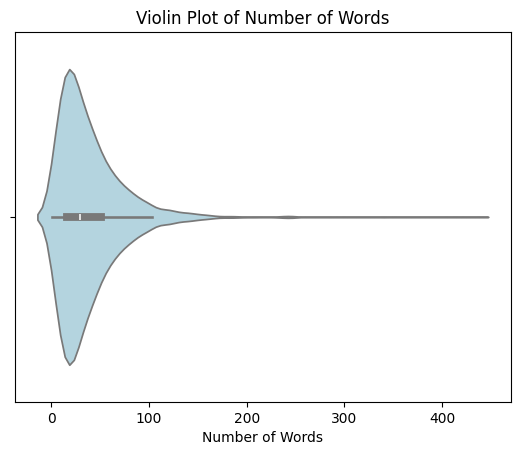

In [13]:
# Initialize violin plot
sns.violinplot(x = string_resp['num_of_words'], color = 'lightblue')

# Add title and labels
plt.title('Violin Plot of Number of Words')
plt.xlabel('Number of Words')

# Show plot
plt.show()

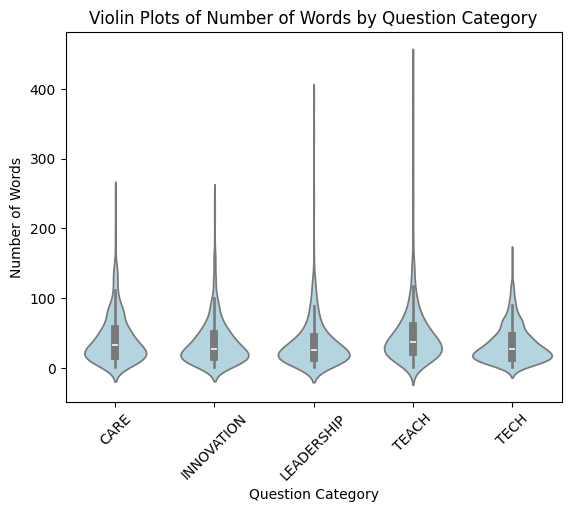

In [14]:
# Create a violin plot for each category in 'question_cat'
sns.violinplot(x = 'question_cat', y = 'num_of_words', data = string_resp, color = 'lightblue')

# Add title, x & y labels, and set xticks
plt.title('Violin Plots of Number of Words by Question Category')
plt.xlabel('Question Category')
plt.ylabel('Number of Words')
plt.xticks(rotation = 45)  

# Show plot
plt.show()


**TukeyHSD Multiple Comparison of Means $\alpha$ = 0.05**

I also applied the tukeyHSD test to the means of the number of words per response of each question category. Recall, previously, LEADERSHIP was distinctly different from all question categories and TEACH was statistically significantly different from TECH. Here, the average number of words per category in a pairwise comparison of means shows LEADERSHIP is *not* statistically significantly different than all other question categories for average number of words used in responses. Rather:

CARE and LEADERSHIP are have statistically significantly different means of words used in responses (p = 0.0385). CARE and TECH also have this difference (p = 0.0058), INNOVATION and TEACH are statistically significantly different (p = 0.0002), LEADERSHIP and TEACH are statistically significantly different (p = 0.0), and TEACH and TECH also have statistically significantly different means of number of words in responses (p = 0.0). CARE is the only question category in relation to TEACH that is not statistically significantly different. Innovation continues to be well understood as it is not statistically significantly different from anything but TEACH. 

In [15]:
# Conduct Tukey HSD test
tukey_results = pairwise_tukeyhsd(endog = string_resp['num_of_words'],
                                 groups = string_resp['question_cat'],
                                 alpha = 0.05)

# View summary output of TukeyHSD
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
CARE,INNOVATION,-4.5781,0.2955,-11.0145,1.8583,False
CARE,LEADERSHIP,-6.6562,0.0385,-13.0926,-0.2199,True
CARE,TEACH,5.4129,0.1465,-1.0234,11.8493,False
CARE,TECH,-8.0603,0.0058,-14.4967,-1.6239,True
INNOVATION,LEADERSHIP,-2.0781,0.9038,-8.5145,4.3583,False
INNOVATION,TEACH,9.9911,0.0002,3.5547,16.4275,True
INNOVATION,TECH,-3.4821,0.5776,-9.9185,2.9542,False
LEADERSHIP,TEACH,12.0692,0.0,5.6328,18.5056,True
LEADERSHIP,TECH,-1.404,0.9758,-7.8404,5.0324,False
TEACH,TECH,-13.4732,0.0,-19.9096,-7.0368,True


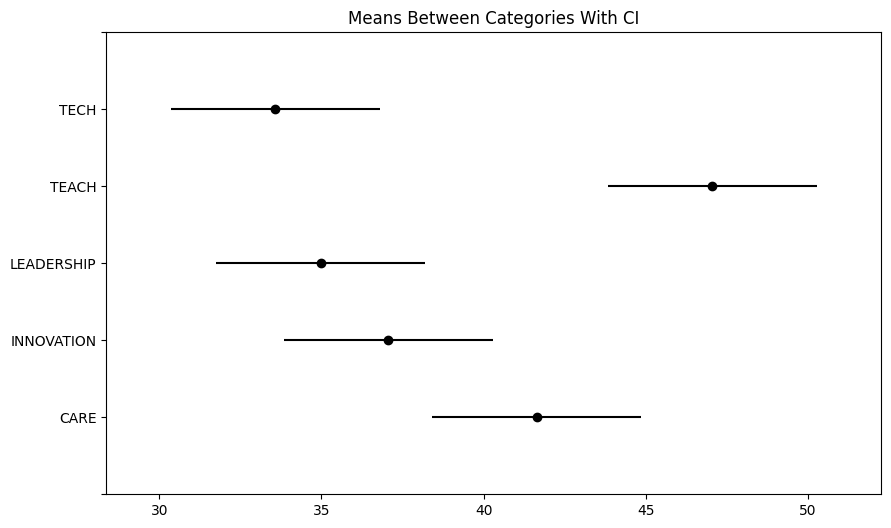

In [16]:
# Plot the means of each category with their confidence intervals 
tukey_results.plot_simultaneous()
plt.title('Means Between Categories With CI')
plt.show()

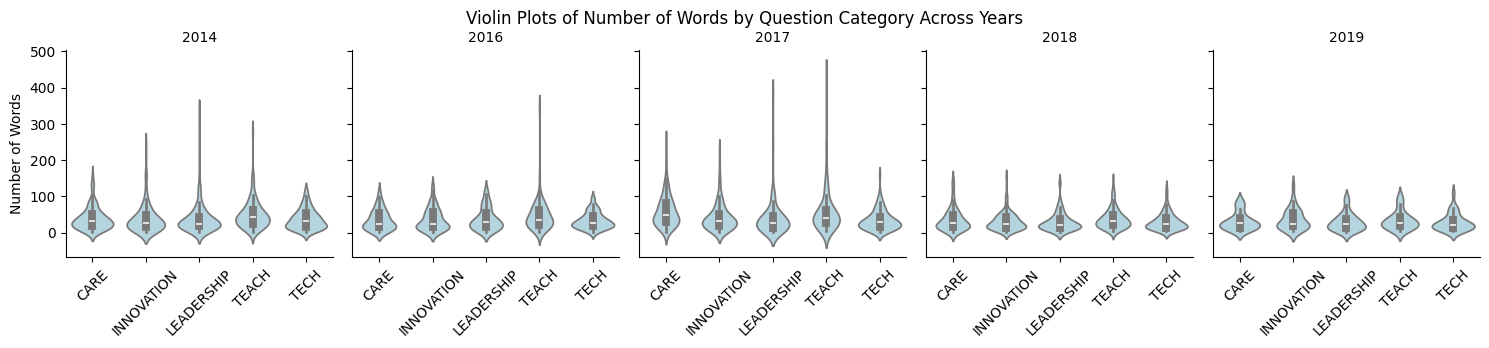

In [17]:
# Create a FacetGrid that generates separate violin plots for each unique 'year'
g = sns.FacetGrid(string_resp, col = 'year', col_wrap = 5, sharex = True, sharey = True)
g.map(sns.violinplot, 'question_cat', 'num_of_words', color = 'lightblue', order = sorted(string_resp['question_cat'].unique()))


# Adjust the title of each subplot to include the year
g.set_titles(col_template = "{col_name}")
g.fig.suptitle('Violin Plots of Number of Words by Question Category Across Years', y = 1.02)
g.set_axis_labels('', 'Number of Words')
g.set_xticklabels(rotation = 45)

# Show plot
plt.show()

### 2022 and 2023

2022 and 2023 started a new rating system that makes that part unique. I had to deal with it in a different way.

In [18]:
# Identify unique ratings values for 2022
unique_vals_2022 = sorted(np.unique(np.concatenate((df2022['TEACH - Rate the nominee and then explain your rating in the question below.'].unique(),
                    df2022['TECH  - Rate the nominee and then explain your rating in the question below.2'].unique(),
                    df2022['CARE - Rate the nominee and then explain your rating in the question below.3'].unique(),
                    df2022['INNOVATION - Rate the nominee and then explain your rating in the question below.4'].unique(),
                    df2022['LEADERSHIP - Rate the nominee and then explain your rating in the question below.5'].unique()))))

# Configure dataframe for 2022
practice_df2022 = configure_dataframe(df2022)

# Make a ratings dataframe for 2022 
ratings_2022 = (pd.DataFrame(practice_df2022[practice_df2022['value'].isin(unique_vals_2022)]
                  .groupby(['question_cat', 'value'])['Start time'].count())
                  .rename(columns = {'Start time':'count'})
                  .reset_index()
                  .sort_values(['question_cat', 'count'], ascending = [True, False])
               )

# Add year
ratings_2022['year'] = 2022

In [19]:
# Identify unique rating vvalues for 2023
unique_vals_in_ratings = sorted(np.unique(np.concatenate((df2023['TEACH - Rate the nominee and then explain your rating in the question below.'].unique(),
                            df2023['TECH - Rate the nominee and then explain your rating in the question below.2'].unique(),
                            df2023['CARE - Rate the nominee and then explain your rating in the question below.3'].unique(),
                            df2023['INNOVATION - Rate the nominee and then explain your rating in the question below.4'].unique(),
                            df2023['LEADERSHIP - Rate the nominee and then explain your rating in the question below.5'].unique()))))

# Configure 2023 dataframe
practice_df2023 = configure_dataframe(df2023)

# Make a 2023 ratings dataframe
ratings_2023 = (pd.DataFrame(practice_df2023[practice_df2023['value'].isin(unique_vals_in_ratings)]
                  .groupby(['question_cat', 'value'])['Start time'].count())
                  .rename(columns = {'Start time':'count'})
                  .reset_index()
                  .sort_values(['question_cat', 'count'], ascending = [True, False])
                )

# Add year
ratings_2023['year'] = 2023

In [20]:
combined_ratings = pd.concat([ratings_2022, ratings_2023]).reset_index(drop =  True)

combined_max_ratings = (combined_ratings.groupby(['year', 'question_cat'])
                            .agg({'count':'mean'})
                            .reset_index()
                            .round(2)
                       )

combined_max_ratings

,year,question_cat,count
0,2022,CARE,25.00
1,2022,INNOVATION,18.75
2,2022,LEADERSHIP,18.75
3,2022,TEACH,37.50
4,2022,TECH,18.75
5,2023,CARE,22.33
6,2023,INNOVATION,16.75
7,2023,LEADERSHIP,16.75
8,2023,TEACH,22.33
9,2023,TECH,16.75


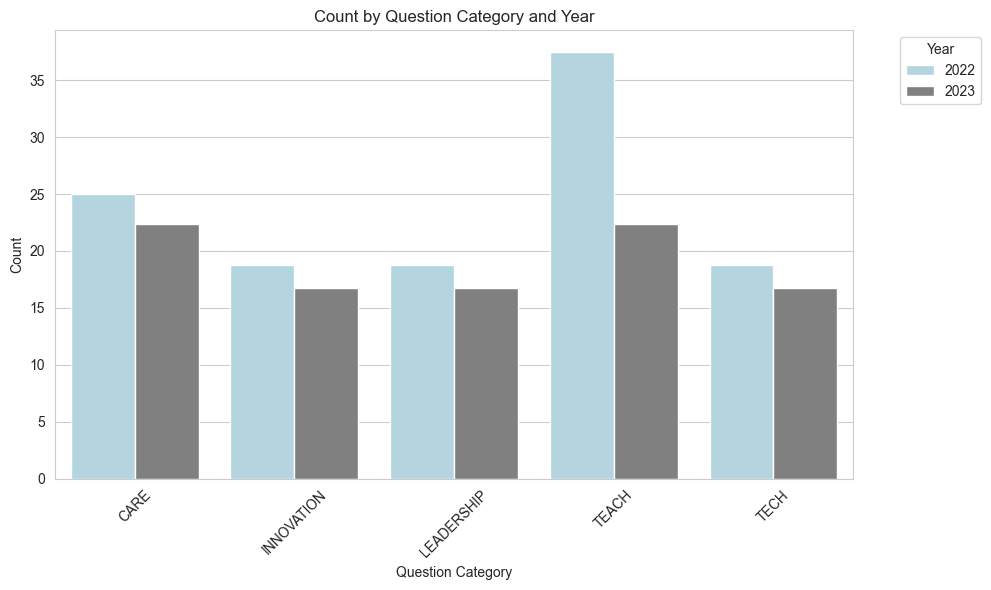

In [21]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data = combined_max_ratings, 
                       x = 'question_cat', 
                       y = 'count', 
                       hue = 'year', 
                       errorbar = None,
                       palette = ['lightblue', 'gray'])

# Set title and labels
plt.title('Count by Question Category and Year')
plt.xlabel('Question Category')
plt.ylabel('Count')

# Rotate the labels on the x-axis
plt.xticks(rotation = 45)

# Set legend location
plt.legend(title = 'Year', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()


In [22]:
# String responses
string_resp2= (pd.concat([practice_df2022[practice_df2022['value'].isin(unique_vals_2022) == False],
                         practice_df2023[practice_df2023['value'].isin(unique_vals_in_ratings) == False]])
                 .fillna('No Response')
                 .reset_index(drop = True)
              )

string_resp2['year'] = string_resp2['Start time'].dt.year

# Count the number of words in each response
string_resp2['num_of_words'] = [len(string_resp2['value'][i].strip().split(' ')) for i in range(len(string_resp2))]

# View number of words for each response for each person
words_per_person = (string_resp2.pivot_table(index = 'Start time', columns = 'question_cat', values = 'num_of_words')
                         .reset_index()
                   )

words_per_person['mean_resp_len'], words_per_person['total_words'] = words_per_person.iloc[:, 1:].mean(axis = 1),\
                                                                     words_per_person.iloc[:, 1:].sum(axis = 1)


# Look at quartiles
quartiles2 = []

for i in string_resp2['question_cat'].unique():
    
    temp = string_resp2[string_resp2['question_cat'] == i]
    temp_desc = (pd.DataFrame(temp['num_of_words'].describe())
                     .reset_index()
                     .rename(columns = {'index':'desc_stats'})
                     .round(2)
                )
    temp_desc['question_cat'] = i
    
    temp_desc = temp_desc[['question_cat', 'desc_stats', 'num_of_words']]
    
    quartiles2.append(temp_desc)
         
(pd.concat(quartiles2)
   .pivot_table(index = 'question_cat', columns = 'desc_stats', values = 'num_of_words')
)

desc_stats,25%,50%,75%,count,max,mean,min,std
question_cat,,,,,,,,
CARE,21.00,34.5,55.00,142.0,179.0,41.97,1.0,30.14
INNOVATION,18.25,31.5,57.00,142.0,175.0,38.18,1.0,27.16
LEADERSHIP,14.00,26.0,40.00,142.0,158.0,32.87,1.0,29.26
TEACH,25.00,42.0,58.75,142.0,295.0,49.06,1.0,37.10
TECH,19.00,29.0,47.75,142.0,166.0,37.56,1.0,28.55


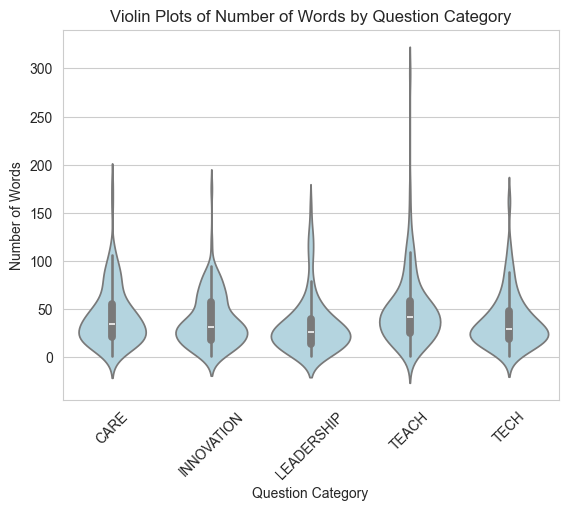

In [23]:
# Create a violin plot for each category in 'question_cat'
sns.violinplot(x = 'question_cat', y = 'num_of_words', data = string_resp2, color = 'lightblue')

# Set title, labels, and angle of xticks
plt.title('Violin Plots of Number of Words by Question Category')
plt.xlabel('Question Category')
plt.ylabel('Number of Words')
plt.xticks(rotation=45) 

plt.show()

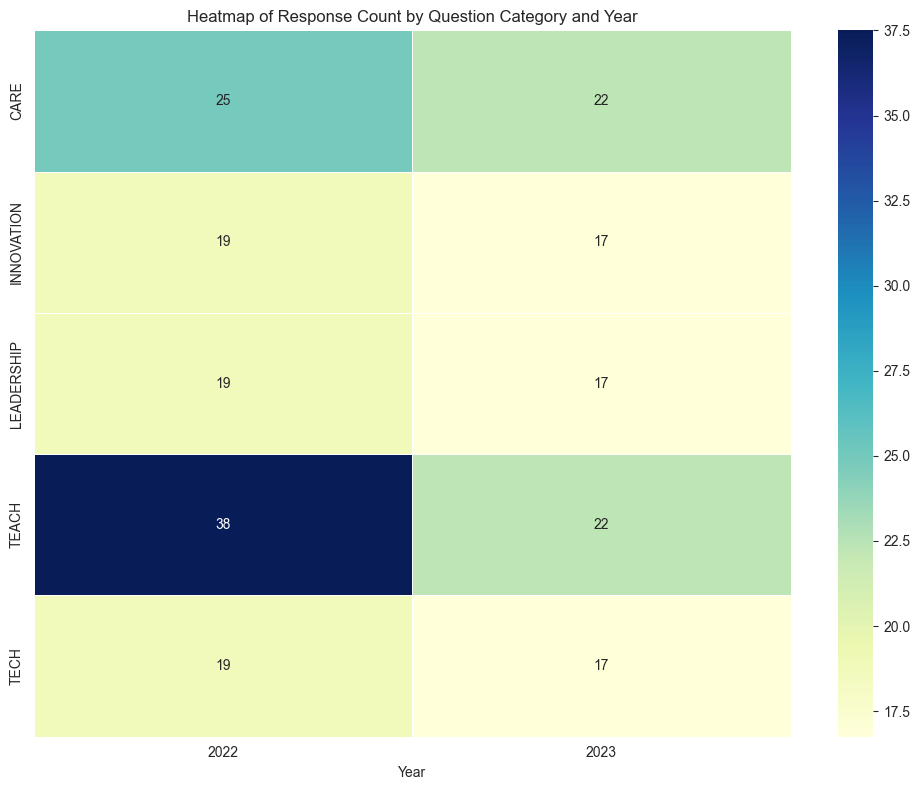

In [24]:
# Convert 'year' and 'question_cat' to string if not already, to ensure they are treated as categorical data
combined_max_ratings['year'] = combined_max_ratings['year'].astype(str)
combined_max_ratings['question_cat'] = combined_max_ratings['question_cat'].astype(str)

# Pivot the DataFrame to prepare for the heatmap
pivot_combined_max_ratings = (combined_max_ratings
                                  .pivot_table(index='question_cat', 
                                               columns='year', 
                                               values='count', 
                                               aggfunc='mean')
                             )

# Create the heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(pivot_combined_max_ratings, annot=True, fmt=".0f", cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Response Count by Question Category and Year')
plt.ylabel('')
plt.xlabel('Year')
plt.tight_layout()

# Display the plot
plt.show()


## Applying Other NLP Algorithms

**Term Frequency-Inverse Document Frequency (TF-IDF)**

This will extract specific words and phrases to identify themes or topics respondents talk about, which should correlate with the question and thus indicate they understand the question.

The IDF component diminishes the weight of terms that occur frequently across the answers to specific questions by including a calculation term that controls for the uniqueness of the word.Terms that appear frequently within a single student's response but not commonly across responses are more informative. This means that even after stopword removal, TF-IDF is distinguishing between merely frequent terms and terms that are both frequent and uniquely informative. 

The Term Frequency (TF) reflects the number of times a term appears in the document to the total number of words in the documen. 

$$TF = \frac{\text{num of times term appears}}{\text{total num of terms in document}}$$

The Inverse Document Frequency (IDF) is calculated by considering the proportin of documents in the analysis that contain the term. If a word appears ina small percentage of documents and is unique, it will receive higher importance scores than words that are more common across all documents.  IDF is calculated as the logarithm of the quotient below:

$$IDF = \frac{\text{num of documents in analysis}}{\text{num of documents that contain term}}$$

The TF-IDF is calculated by multiplying the TF by the IDF scores.

$$\text{TF-IDF} = TF * IDF$$

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Load English stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation
    filtered_tokens = [word for word in tokens if word.isalnum() and word.lower() not in stop_words]
    # Re-join tokens into a string
    return ' '.join(filtered_tokens)

# Apply preprocessing to the 'value' column
string_resp['processed_value'] = string_resp['value'].apply(preprocess_text)

# Group by 'question_cat' and concatenate all 'processed_value' in each group
grouped_responses = string_resp.groupby('question_cat')['processed_value'].apply(lambda x: ' '.join(x)).reset_index()


In [26]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the concatenated responses
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_responses['processed_value'])

# Now, 'tfidf_matrix' contains the TF-IDF scores for each word in each question category
# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

# Add the question categories as an index to make it identifiable
tfidf_df.index = grouped_responses['question_cat']

In [27]:
from preprocess import top_terms_by_category

top_terms_by_category(tfidf_df, 10)

,CARE,INNOVATION,LEADERSHIP,TEACH,TECH
also,0.000000,0.000000,0.000000,0.000000,0.162874
always,0.172214,0.172669,0.164786,0.183827,0.000000
butler,0.000000,0.000000,0.208406,0.000000,0.000000
canvas,0.000000,0.000000,0.000000,0.000000,0.239438
class,0.301374,0.284396,0.150246,0.274183,0.273328
college,0.000000,0.000000,0.244756,0.000000,0.000000
committees,0.000000,0.000000,0.217462,0.000000,0.000000
help,0.209886,0.164543,0.000000,0.163575,0.000000
involved,0.000000,0.000000,0.201136,0.000000,0.000000
know,0.000000,0.000000,0.242333,0.000000,0.000000


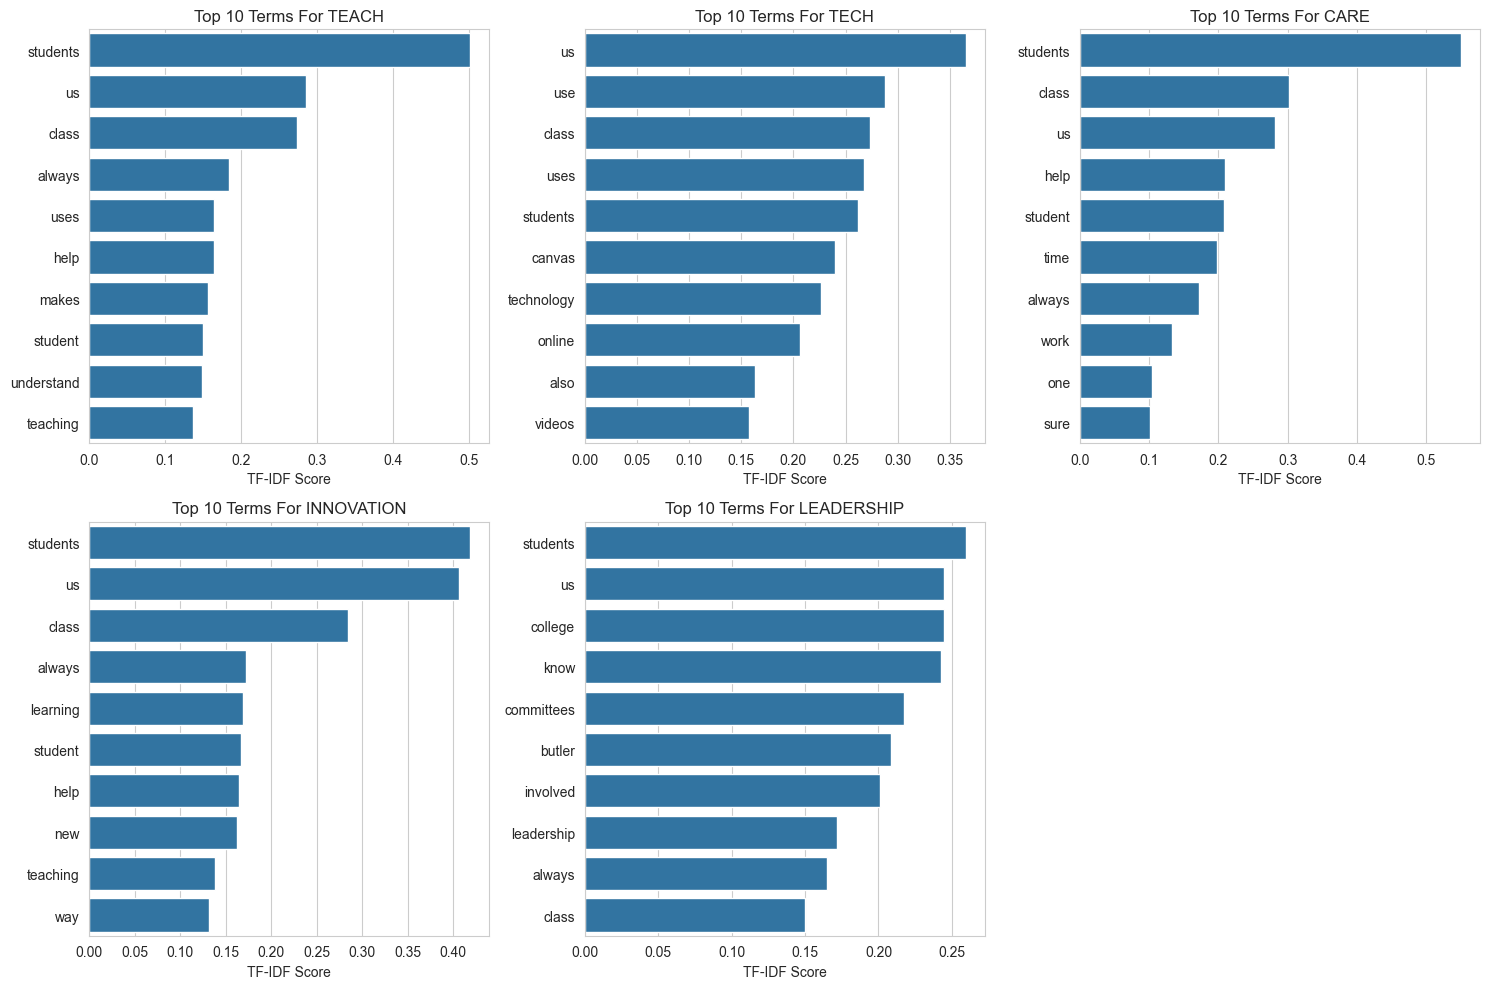

In [28]:
# Visualize the top 10 TF-IDF scores for a specific question category
def visualize_top_terms(ax, tfidf_dataframe, category, top_n = 10):
    top_terms = (tfidf_dataframe
                     .loc[category]
                     .sort_values(ascending = False)
                     .head(top_n)
                 )
    sns.barplot(x = top_terms.values, y = top_terms.index, ax = ax)
    ax.set_title(f'Top {top_n} Terms For {category}')
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('')

# Set num of rows and cols
n_rows = 2
n_cols = 3

# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (15, 10))

# Flatten the axes for indexing
axes_flat = axes.flatten()

# Loop through categories
for i, cat in enumerate(award_cats):
    visualize_top_terms(axes_flat[i], tfidf_df, cat, 10)
    
# Hide the last subplot if empty
if len(award_cats) < n_rows * n_cols:
    for j in range(len(award_cats), n_rows * n_cols):
        fig.delaxes(axes_flat[j])
    
# Show plot
plt.tight_layout()
plt.show()

**TF-IDF Analysis**

The bar charts reinforce what has already been observed with the Keyword Frequency Analysis (KFA). We see very distinctive themes emerge in the weighted words for TEACH, CARE, and INNOVATION. TECH has a more uniform distribution (though obviously not entirely uniform), and LEADERSHIP has an even closer uniform distribution. These characteristics at least point to the reality that these questions and themes are less understood by the student. 

### Latent Dirichlet Allocation Model (LDA)

This is an unsupervised learning algorithm that helps identify topics present across the dataset. If responses to certain questions consistently cluster around unrelated topics, it might indicate misunderstanding. The coherecne score measures the semantic similarity between high scoring words within each question category, which provides a metric for understanding how important and interpretable certain topics are. Nevertheless, it is not the only point of consideration. The number of topics as well as the coherency score create a fuller picture. If the max coherency score occurs within fewer topics, it might indicate that the question category is well understood and, thus, the answers cluster around one or two topics. If the responses cluster around three or more topics, it could indicate that the question is not well understood. 

In the context of evaluating topic models using the C_V coherence measure, as I did here, the segmentation is accomplished through the S-one-set method, which means the coherence measure is calculated based on the relationship between individual words and a collective set of words. 

The probability calculation in C_V is calculated using the method Psw(110), which is enabled by a sliding window size of 110 units. The window traverses the entire textual corpus, which allows the model to calculate the occurrence and co-occurrence probabilities of words within the defined window. By utilizing the sliding window technique, local contexts and relationships between words are captured. 

The confirmation measure utilizes the m_nlr measure by comparing the words of each pair of words against all other words in the corpus. This comparison is not a direct comparison but instead evaluates how the presence of one word affects the probability of observing other words and will be represented in vectors. The coherence score is derived from the cosine similarity between these vectors, which is the angle between two vectors, denoting how closely related the vectors are in the context of their orientation in the vector space. 

The cosine similarity between two vectors $\mathbf{A}$ and $\mathbf{B}$ is defined as the cosine of the angle $\theta$ between them. The formula for cosine similarity can be directly dirived from the definition of the dot product of two vectors and the cosine of the angle between them. The dot product of $\mathbf{A}$ and $\mathbf{B}$ is equal to the product of their magnitudes and the cosine of the angle $\theta$ between them:

$\mathbf{A} \cdot \mathbf{B} = \|\mathbf{A}\| \|\mathbf{B}\| \cos(\theta)$

Where:

* $\mathbf{A} \cdot \mathbf{B}$ is the dot product of the vectors $\mathbf{A}$ and $\mathbf{B}$.
* $\|\mathbf{A}\|$ and $\|\mathbf{B}\|$ are the magnitudes (or norms) of vectors $\mathbf{A}$ and $\mathbf{B}$, respectively.
* $\cos(\theta)$ is the cosine of the angle $\theta$ between vectors $\mathbf{A}$ and $\mathbf{B}$.

The cosine similarity $\text{sim}(\mathbf{A}, \mathbf{B})$ is then the cosine of the angle $\theta$ normalized by the magnitudes of the vectors:

$\text{sim}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \cos(\theta)$

This measure determines how closely related the vectors are in the context of their orientation in the vector space, which is how the semantic similarity between the words is represented. 

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils
from scipy.linalg import get_blas_funcs, triu

def coherence_model(df, token_col, grouping_col, award_cat, num_of_topics):
    # Tokenize the processed text
    df['tokens'] = df[token_col].apply(word_tokenize)

    # Create a Gensim dictionary from the tokenized data
    tokenized_data = df[(df[grouping_col] == award_cat)]['tokens'].tolist()
    #tokenized_data = string_resp['tokens'].tolist()
    dictionary = corpora.Dictionary(tokenized_data)

    # Filter out extremes to remove very rare and very common words
    dictionary.filter_extremes(no_below = 5, no_above = 0.5)

    # Convert dictionary into a bag of words corpus
    corpus = [dictionary.doc2bow(text) for text in tokenized_data]

    # Number of topics
    num_topics = num_of_topics

    # Build LDA model
    lda_model = LdaModel(corpus = corpus,
                         id2word = dictionary,
                         num_topics = num_topics,
                         random_state = 101,
                         update_every = 1,
                         chunksize = 100,
                         passes = 10,
                         alpha = 'auto')
    
    # View the topics in LDA model
    lda_mod = {}
    for idx, topic in lda_model.print_topics(-1):
        lda_mod[idx] = topic
    
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model = lda_model, 
                                         texts = tokenized_data, 
                                         dictionary = dictionary, 
                                         coherence = 'c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    
    return lda_mod, coherence_lda


In [ ]:
# Flip through coherence model and store coherence levels at various numbers of 
# "topics". I stored the coherence with 1 through 10 topics.

coherence_mod = {}

for i in award_cats:
    temp_list = []
    for j in range(1, 11, 1):
        temp = coherence_model(string_resp, 'processed_value', 'question_cat', i, j)
        temp_list.append(temp[1])
    coherence_mod[i] = temp_list

In [ ]:
# Show coherence scores for different numbers of topics. The max value for each question_cat
# in relation to topic number is the optimal topic number for that category.
pd.DataFrame.from_dict(coherence_mod, orient = 'index').T

In [ ]:
#coherence_model(string_resp, 'processed_value', 'question_cat', 'LEADERSHIP', 6)[0]

### Number of Topics That Produce Best Coherence Scores

|**Question_Cat**|**Num_Of_Topics**|**Coherence_Score**|
|:---------------|----------------:|------------------:|
|TEACH           | 1               | 	0.387145       |
|TECH 	         | 1               |    0.413440       |
|CARE 	         | 5               |    0.417541       |
|INNOVATION      | 2               |  	0.433722       |
|LEADERSHIP      | 6               |	0.404134       |

<br><br><br><br><br><br><br><br>

**First Impressions**

Part of the Coherence Model is not just what the max coherency score is but also how many topics the responses cluster around to reach the max coherency score. Thus, we see that it appears TEACH, TECH, and INNOVATION are relatively straightforward as the responses from students cluster around one topic for the first two and two topics for the latter option. Surprisingly to me, CARE clustered around five topics to reach its maximum coherency score, which indicates that students conceive of CARE in many different ways. LEADERSHIP is the non-surprise as it has six clusters of topics from the student responses, indicating it is not a well understood question.

I wanted to create a summary of each topic for each question category as I did before but based on the Coherence Model. The section that follows is for that purpose.

**TEACH**

* *Supportive and engaging teaching methods*: This topic centers around the ability of the nominee to make the class engaging, their availability and eagerness to help studnets, and their effectiveness in making the material understandable. 

* *Insights*: Questions should focus on drawing out responses that highlight professors who prioritize student understanding and engagement through their teaching, exploring the methods professors use to keep the material accessible and engaging. 

* **Possible Questions**

    * How does the professor make the class engaging and ensure that students are actively participating?
    * When has the professor gone out of their way to make sure you understood a difficult concept?

**TECH**

* *Effective use of tech in the classroom*: This topic highlights how professor's use tech to enhance learning experience and also how they encourage students to utilize new technological tools and resources. It further emphasizes how the nominee is adept at incorporating digital tools into their teaching methods, making classes more interactive and accessible. 

* *Insight*: Questions in this category should aim to uncover how professors integrate digital tools to support student learning, promote engagement, and enhance the accesssibility of course materials. Moreover, these questions should explore the effectiveness of these technological approaches in improving student outcomes and the overall learning experience.

* **Possible Questions**

    * How does the professor integreate technology into their teaching to enhance learning and student engagement?
    * Describe the ways in which the use of video, Canvas, or other digital materials enhanced your understanding of the course content.

**CARE**

* *Academic time management*: In this topic, the students' responses clustered around the idea that the professor not only made him/herself available for office hours, but also was aware of the semester workload and designed the class well, highlighted assignment deadlines (even though they are in the syllabus and in Canvas), and balanced day-to-day activities.

* *Supportive Classroom Environment*: This clustering of responses focuses on the professor's consistent effort to assist students within the classroom and highlights how these professors were avaialble, tailored their teaching to individual student needs, and fostered a supportive learning environment.

* *Personalized assistance and life guidance*: Topic three centeres around help and mentorship, emphasizing the impact professors have in guiding students through personal challenges, academic decisions, and life transitions. It reflects the intentional effort the professor puts into one-on-one level interactions with students that extends beyond the usual academic instruction.

* *Inclusivity and emotional support*: These professors are particularly adept at creating environments in which students feel included and understood, emphasizing empathy, understanding, and assurance that students have a support system. 

* *Holisitc educational experience*: The final topic focuses on how the professors facilitate CARE by aiding students in their personal growth, social skills, and preparation for life beyond school. 

* *Insights*: Questions that might draw out these topics should focus on the multifaceted nature of student support, encompassing academic assistanc, time management, emotional well-being, inclusivity, and life skills development. 

* **Possible Questions**

    * How did the nominee develop time management skills to help students struggling with assignment deadlines?
    * In what ways did the nominee tailor their teaching methods or classroom environment to support individual student needs and foster a supportive learning atmosphere?
    * Describe a situation in which the nominee provided personalized guidance or mentorship to you that helped you navigate personal challenges or your academics.
    * How did the nominee promote an inclusive classroom environment where every student felt valued and supported, both academically and emotionally?
    * What approaches did the nominee utlize that enhanced the overall educational experience, that addressed aspects beyond academics, such as personal growth and social skills?
    * How has the nominee enhanced your development and success as a student, particularly in areas like study skills, life skills, and prepareing for the future?
    
**INNOVATION**

* *Student-centric innovation*: This theme notes how professors integrate new ways of teaching that specifically enhance student learning and success. The emphasis here is on teaching methodologies that address the diverse needs of studens and foster an environment in which various learning styles are acknowledged and supported. These professors stop at nothing to make sure students grasp the material, which pushes them to try new pedagogical approaches and integrate new software where appropriate. 

* *Insights*: Questions in this category should focus on uncovering specific innovative and supportive teaching practices that contribute to student learning and engagement with special attention paid to how professors adapt their teaching methods to meet the diverse needs of their students.

* **Possible Questions**

    * Describe a unique projfect or assignment that challenged conventional learning methods.
    * How has the professor incorporated new technologies or digital learning tools that enhanced your learning, understanding, and engagement?
    * How has the professor encouraged creativity in your approach to learning and problem-solving within the class?
    * What impact did implemnting new teaching methods and tools during your course have on your learning experience?
    * What teaching method did the professor use that was most effective for you understanding the material?
   
**LEADERSHIP**

* The themes are not particularly useful here. This is discussed in the final analysis.

### Final Analysis of LDA

As mentioned previously, to undersand the usefullness of LDA, we have to break down its output into both the number of topics a response clusters around and the maximum coherence score. The *coherence score* evaluates the quality of the topics generated; the higher the score, the more it appears that the question category is meaningful and interpretable to the students. The number of clusters of topics before reaching the maximum coherence score is a good proxy for identifying whether students understand what the question is asking for. The higher the number of clusters for a question category before reaching maximum coherence, the more indication we have that the question is not well understood or has significant nuance between students.

Both TEACH and TECH have single topic clusters along with their coherence scores. This is in contrast to the original Keyword Frequency Analysis that suggests that TECH is one of the lesser understood question categories. 

INNOVATION has only two topic clusters and the highest coherence score at 0.433722, which indicates there is strong understanding among students about what innovation in teaching is. 

CARE has five topic clusters before it reaches its maximum coherence score, which highlights how nuanced *care* is for students. To some degree, this is not surprising because defining care is pretty nebulous. Therefore, we should probably work more diligently to direct students toward identifying care in the classroom. 

Finally, LEADERSHIP delivered what we expected, six different topics before it reached its maximum coherence score, which suggests the question and concept are too vague for students to hone in on one or two themes. Students struggle to identify leadership in their professors precisely because the question in the past has asked them to know what their professors are doing within the organization outside of the classroom. 